In [2]:
# Import dependencies
from pathlib import Path
import pandas as pd
import sqlite3

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import tensorflow as tf
import keras_tuner as kt

In [2]:
# Connect to the database
con = sqlite3.connect('resources/heart.sqlite') 

# Run SQL on table         
sql_query = pd.read_sql('SELECT * FROM original', con)

# Display query results
sql_query.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
# Convert SQL to Pandas DataFrame
df = pd.DataFrame(sql_query, columns = ['Age',
                                        'Sex',
                                        'ChestPainType',
                                        'RestingBP',
                                        'Cholesterol',
                                        'FastingBS',
                                        'RestingECG',
                                        'MaxHR',
                                        'ExerciseAngina',
                                        'Oldpeak',
                                        'ST_Slope',
                                        'HeartDisease']
                 )

# Preview newly created DF
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
# Check columns and data types
print(df.columns)
df.dtypes

# Upon initial review, no columns need recasting (.astype)

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')


Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [5]:
# Generate summary statistics for dataset
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [6]:
# Check for nulls
df.isnull().sum()

# The dataset does not appear to contain any explicit null (NaN) values

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [7]:
# Check for values of zero in features that are int or float, as these may be spurious
age_zero = (df[['Age', 'RestingBP', 'Cholesterol', 'FastingBS',	'MaxHR', 'Oldpeak']] == 0).sum()
print(age_zero)
# The zeros in cholesterol and RestingBP are undesirbale. These zeros are addressed in Data_Cleaning.ipynb

Age              0
RestingBP        1
Cholesterol    172
FastingBS      704
MaxHR            0
Oldpeak        368
dtype: int64


In [ ]:
#Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh','sigmoid'])
    
    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=10,
        step=2), activation=activation, input_dim=20))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 6)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=10,
            step=2),
            activation=activation))
    
    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    
    return nn_model

In [ ]:
#Creating the method of identifying the best model for a given DataFrame, also passes in the directory where the trials will be stored.

def hyperband_tuner_best_model(df, directory):
    # Split our preprocessed data into our features and target arrays
    y = df['HeartDisease']
    X = df.drop(columns='HeartDisease')
    
    # Convert categorical data to numeric with `pd.get_dummies`
    X = pd.get_dummies(X)
    X.head()

    # Split the preprocessed data into a training and testing dataset, used random_state = 1 for inital results
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    # Create a StandardScaler instances
    scaler = StandardScaler()

    # Fit the StandardScaler
    X_scaler = scaler.fit(X_train)

    # Scale the data
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)

    print(X_train.shape)
    # Our models will be training on 20 parameters.

    #Create the tuner with the hyperband method

    tuner = kt.Hyperband(
        create_model,
        objective="val_accuracy",
        max_epochs=20,
        overwrite=True,
        directory = directory,
        hyperband_iterations=1)

    #Run the kerastuner search for best hyperparameters
    tuner.search(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test))

    #Get best model hyperparameters
    best_hyper = tuner.get_best_hyperparameters(1)[0]
    best_hyper.values

    # Evaluate best model against full test data
    best_model = tuner.get_best_models(1)[0]
    model_loss, model_accuracy = best_model.evaluate(X_test_scaled,y_test,verbose=2)
    print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

In [ ]:
#Run the hyperband tuner with the initial data
hyperband_tuner_best_model(df, "initial_data")

### Initial Accuracy: 91.74%, Loss: 30.31%

### Attempt 2 with No Zeros

In [ ]:
# Create a path reference to the file 
heart_path_no_zero = Path("resources/heart_no_zeros.csv")

# Read CSV into DataFrame
df_no_zeros = pd.read_csv(heart_path_no_zero, delimiter=",")

# Preview DataFrame
df_no_zeros.head()

In [ ]:
#Run the hyperband tuner with the data with the zeros removed
hyperband_tuner_best_model(df_no_zeros, "no_zeros")

### Accuracy 89.30%, Loss 45.07%

### Attempt 3 with Replaced Values

In [3]:
# Create a path reference to the file 
heart_path_replaced = Path("resources/heart_replaced_values.csv")

# Read CSV into DataFrame
df_replaced = pd.read_csv(heart_path_replaced, delimiter=",")

# Preview DataFrame
df_replaced.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [ ]:
#Run the hyperband tuner with the data with the zeros replaced
hyperband_tuner_best_model(df_replaced, "replaced_values")

### Accuracy 90.9%, Loss 30.3%

In [ ]:
#Make a new df with one-hot encoding in order to find the correlation between the variables and HeartDisease
df_corr = pd.get_dummies(df_replaced)
correlations = df_corr.corr()["HeartDisease"]
correlations.sort_values(ascending = False)

## Random Forest

In [4]:
# Split our preprocessed data into our features and target arrays
y = df_replaced['HeartDisease']
X = df_replaced.drop(columns='HeartDisease')

In [5]:
# Convert categorical data to numeric with `pd.get_dummies`
X = pd.get_dummies(X)
X.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,False,True,False,True,False,False,False,True,False,True,False,False,False,True
1,49,160,180,0,156,1.0,True,False,False,False,True,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,False,True,False,True,False,False,False,False,True,True,False,False,False,True
3,48,138,214,0,108,1.5,True,False,True,False,False,False,False,True,False,False,True,False,True,False
4,54,150,195,0,122,0.0,False,True,False,False,True,False,False,True,False,True,False,False,False,True


In [6]:
# Split the preprocessed data into a training and testing dataset, used random_state = 1 for inital results
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [7]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

print(X_train.shape)

(688, 20)


In [8]:
#Create the random forest model
rf_model = RandomForestClassifier().fit(X_train_scaled, y_train)

In [9]:
#Make predictions on heart disease through the model
predictions = rf_model.predict(X_test_scaled)

# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [10]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,72,17
Actual 1,15,126


Accuracy Score : 0.8608695652173913
Classification Report
              precision    recall  f1-score   support

           0       0.83      0.81      0.82        89
           1       0.88      0.89      0.89       141

    accuracy                           0.86       230
   macro avg       0.85      0.85      0.85       230
weighted avg       0.86      0.86      0.86       230



### Accuracy 86.1%

In [11]:
# Get the feature importance array which lists which parameters had the most impact in determining heart disease
importances = rf_model.feature_importances_
# List the top 10 most important features
importances_sorted = sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)
importances_sorted[:10]

[(0.1715670539956648, 'ST_Slope_Up'),
 (0.10124050240683653, 'Oldpeak'),
 (0.09466480980401691, 'MaxHR'),
 (0.08858913770815437, 'ChestPainType_ASY'),
 (0.08823056752773961, 'ST_Slope_Flat'),
 (0.07542495908380693, 'Cholesterol'),
 (0.07234020518691882, 'Age'),
 (0.067360441505898, 'RestingBP'),
 (0.04491182674385335, 'ExerciseAngina_Y'),
 (0.037299986821282334, 'ExerciseAngina_N')]

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

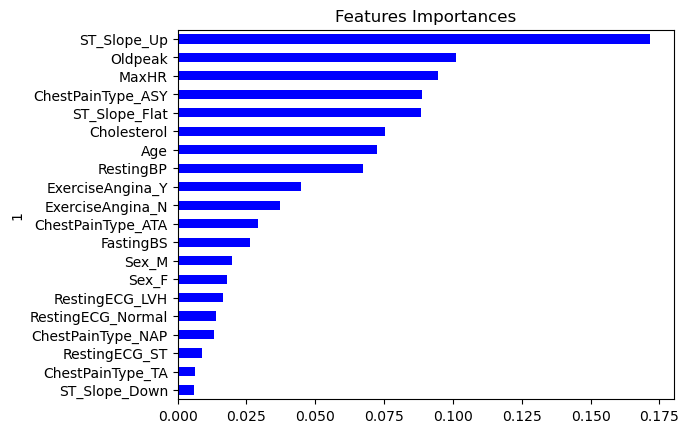

In [17]:
#Create a DataFrame of the feature_importance and then create a horizontal bar chart to display
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='blue', title= 'Features Importances', legend=False)

## Logisitic Regression

In [14]:
# Create a logistic regression model and use it to make predictions on heart disease
log_classifier = LogisticRegression(solver="lbfgs").fit(X_train_scaled, y_train)
predictions = log_classifier.predict(X_test_scaled)  

In [15]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [16]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,72,17
Actual 1,17,124


Accuracy Score : 0.8521739130434782
Classification Report
              precision    recall  f1-score   support

           0       0.81      0.81      0.81        89
           1       0.88      0.88      0.88       141

    accuracy                           0.85       230
   macro avg       0.84      0.84      0.84       230
weighted avg       0.85      0.85      0.85       230



### Accuarcy 85.2%